In [1]:
from Model.Energy import VonMisesFischerEnergy
from Model.Proposal import VonMisesFischerProposal
from Data import get_dataloader_from_data
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from Model.Trainer import SNLTrainer

/opt/miniconda3/envs/lime_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Target Distribution 

In [2]:
target_distribution = torch.distributions.VonMises(0 , 10)

In [3]:
sample_target_polar = target_distribution.sample((20000,))
sample_target_cartesian = torch.stack([torch.cos(sample_target_polar), torch.sin(sample_target_polar)], dim=1)


dataset_total = TensorDataset(sample_target_cartesian, )
data_train, data_val, data_test = torch.utils.data.random_split(dataset_total, [10000, 5000, 5000])
dataloader_train = DataLoader(data_train, batch_size=100, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=100, shuffle=False)

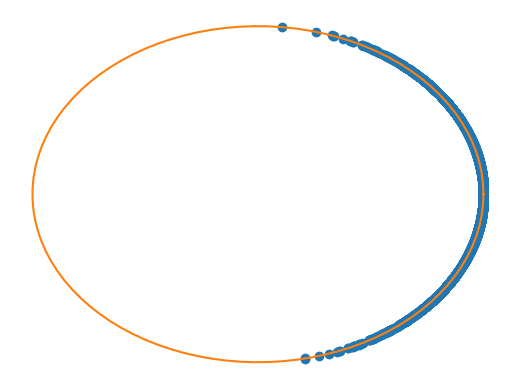

In [4]:

# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# ax.set_theta_zero_location('N')
# ax.set_theta_direction(-1)
# ax.set_rticks([])
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)
ax.plot(sample_target_cartesian[:, 0], sample_target_cartesian[:, 1], 'o')
ax.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)))
plt.show()


# Proposal Distribution :

In [5]:
proposal_distribution = VonMisesFischerProposal(input_size= torch.Size([1,]),mu = torch.ones((2,),), kappa= torch.tensor(1.0))

Init Standard Gaussian...


In [6]:
print(proposal_distribution.input_size)

torch.Size([1])


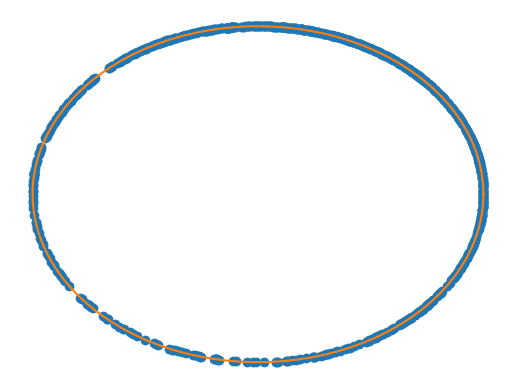

In [7]:
sample_proposal_cartesian = proposal_distribution.sample(1000)
sample_proposal_polar = torch.atan2(sample_proposal_cartesian[:, 1], sample_proposal_cartesian[:, 0])
# Plot a circle and sample from the von Mises distribution
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)
ax.plot(sample_proposal_cartesian[:, 0], sample_proposal_cartesian[:, 1], 'o')
ax.plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)))
plt.show()


In [8]:
proposal_distribution.log_prob(sample_proposal_cartesian)

tensor([[-1.1070],
        [-1.5201],
        [-1.0953],
        [-1.9539],
        [-1.1077],
        [-1.4515],
        [-1.1017],
        [-1.7320],
        [-1.6469],
        [-1.0981],
        [-1.0739],
        [-1.8517],
        [-1.2467],
        [-1.0817],
        [-2.4892],
        [-1.6551],
        [-1.5784],
        [-1.5887],
        [-1.9690],
        [-1.9241],
        [-1.6993],
        [-1.3188],
        [-1.3705],
        [-2.8945],
        [-1.2452],
        [-1.1178],
        [-1.7834],
        [-2.3440],
        [-2.7090],
        [-1.2161],
        [-2.5745],
        [-1.2485],
        [-2.4449],
        [-1.1038],
        [-1.0765],
        [-1.1620],
        [-1.6605],
        [-1.3570],
        [-1.5552],
        [-1.0780],
        [-1.9627],
        [-2.5878],
        [-1.1053],
        [-1.0981],
        [-1.0843],
        [-1.0740],
        [-1.2644],
        [-1.1495],
        [-1.2229],
        [-1.1372],
        [-1.1218],
        [-1.2406],
        [-1.

# Energy

In [9]:
energy = VonMisesFischerEnergy(learn_mu=True, learn_kappa=True)

In [10]:
energy(x = sample_target_cartesian)

tensor([-2.1618, -1.7347, -2.5999,  ..., -1.0444, -1.7897, -2.6807],
       grad_fn=<NegBackward0>)

# Trainer :


In [11]:
trainer = SNLTrainer(energy=energy, proposal=proposal_distribution, dataloader=dataloader_train, val_dataloader=dataloader_val , n_sample_train=1000, n_sample_test=1000, lr=0.01, )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hugosenetaire. Use `wandb login --relogin` to force relogin


In [12]:
trainer.train(n_iter=20000, n_iter_pretrain=1000,)

Step 0
Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Step 6000
Step 7000
Step 8000
Step 9000
Step 10000
Step 11000
Step 12000
Step 13000
Step 14000
Step 15000
Step 16000
Step 17000
Step 18000
Step 19000
Step 20000


In [13]:
from IPython.display import clear_output



def live_plot(loss_target_list, loss_proposal_list, loss_list, kappa, mu, kappa_grad, mu_grad, title=''):
    clear_output(wait=True)

    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    ax = ax.flatten()
    ax[0].set_title('Loss')
    ax[1].set_title('Loss target')
    ax[2].set_title('Loss proposal')
    ax[3].set_title('Kappa')
    ax[4].set_title('Mu')
    ax[5].set_title('Kappa Grad')
    ax[6].set_title('Mu Grad')


    ax[0].plot(loss_list, label='Loss')
    ax[1].plot(loss_target_list, label='Loss target')
    ax[2].plot(loss_proposal_list, label='Loss proposal')
    ax[3].plot(kappa, label='Kappa')
    ax[4].plot(mu, label='Mu')
    ax[5].plot(kappa_grad, label='Kappa Grad')
    ax[6].plot(mu_grad, label='Mu Grad')



    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()




def snl(energy_model,proposal_distribution, target_samples_torch, proposal_samples_torch, n_iter=10000, n_pre_iter=10000, lr=1e-4):
    kappa_list = []

    kappa_grad_list = []
    mu_list = []
    mu_grad_list = []
    loss_target_list = []
    loss_proposal_list = []
    loss_list = []

    # Plot the curve of the loss as it evolves






    optimizer = torch.optim.Adam(energy_model.parameters(), lr=lr)
    optimizer_log_bias = torch.optim.Adam([energy_model.log_bias], lr=1e-2)
    for i in range(n_pre_iter+n_iter):
        optimizer.zero_grad()
        optimizer_log_bias.zero_grad()
        optimizer.zero_grad()
        energy_target = energy_model(x = target_samples_torch) 
        log_z_estimation = -energy_model(x = proposal_samples_torch) - energy_model.log_bias
        torch.arctan2(proposal_samples_torch / proposal_samples_torch.norm(dim=1, keepdim=True), proposal_samples_torch / proposal_samples_torch.norm(dim=1, keepdim=True))
        log_prob_proposal = proposal_distribution.log_prob(proposal_samples_torch).sum()

        loss_target = energy_target.mean()
        loss_proposal = log_z_estimation.logsumexp(dim=0).exp().mean() + energy_model.log_bias - 1
        loss =  loss_target + loss_proposal
        loss.backward()
        if i >= n_pre_iter:
            optimizer.step()
        else :
            optimizer_log_bias.step()


        for name, param in energy_model.named_parameters():
            if param.requires_grad:
                if name == 'log_kappa':
                    kappa_list.append(param.item())
                    kappa_grad_list.append(param.grad.item())
                if name == 'mu':
                    mu_list.append(param.item())
                    mu_grad_list.append(param.grad.item())
        loss_target_list.append(loss_target.item())
        loss_proposal_list.append(loss_proposal.item())
        loss_list.append(loss.item())

        if i % 100 == 0:

            real_normalisation_constant = energy.log_normalisation_constant().item()

            live_plot(loss_target_list, loss_proposal_list, loss_list, kappa_list, mu_list, [], [], title='SNL')



